# Exploring Spotify Listening History

## A Quarantine Project

#### In the summer of 2017, I created a last.fm account (https://www.last.fm/user/gps56) in order to record my listening habits on Spotify.  Last.fm allows you to link music streaming services, and serves to record your listens (referred to as 'scrobbles').  You can download your data to csv, or use last.fm's API to pull it directly.  

#### I love music and I love coding (particularly data science), so over the past few weeks I used my free time in quarantine to take a peek into my listening habits.  I had 3 years of listening history and over 50,000+ song listens to wade through.  Take a look!

First, importing packages I used.

I primarily used `pandas` for interacting with the data.  `pandas` has a weird quirk where it warns you whenever you create a new column as a reference to a previous one.  This can get messy if you're going to be mangling columns, but if you're mostly just creating new columns and leaving previous ones untouched, you can turn off the warning.

In [1]:
import os, sys
import pandas as pd, numpy as np
import datetime, time

pd.options.mode.chained_assignment = None

I downloaded my scrobbling history to a csv.  Read into a `pandas` `DataFrame` as usual.  The flat file contains artist/album/song along with the date/time of each listen.

In [2]:
__scrobbles__ = 'downloads/gps56-2.csv'

df = pd.read_csv(__scrobbles__, header = None, names = ['artist', 'album', 'song', 'datetime'])

#### Some preliminary preprocessing

Remove any records that have blank date/time info (there should be none).
The date/time column is given in UTC.  Since I've spent the past 3 years living in NYC, I'll subtract 5 hours from this.

In [3]:
df = df[~df.datetime.isna()]
df.datetime.isna().value_counts()

False    55281
Name: datetime, dtype: int64

In [4]:
df.datetime = pd.to_datetime(df.datetime) - pd.Timedelta(hours = 5)

Here's what the 10 most recent listens are (at the time of downloading the data).

In [5]:
df.head(10)

,artist,album,song,datetime
1,Drake,Dark Lane Demo Tapes,Pain 1993 (with Playboi Carti),2020-05-04 19:34:00
2,Juice WRLD,Death Race For Love,Empty,2020-05-04 17:07:00
3,Juice WRLD,Death Race For Love,Rider,2020-05-04 17:05:00
4,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 17:05:00
5,Juice WRLD,Death Race For Love,She’s The One,2020-05-04 16:58:00
6,Juice WRLD,Death Race For Love,10 Feet,2020-05-04 16:56:00
7,Juice WRLD,Death Race For Love,Ring Ring (with Rvssian feat. Clever),2020-05-04 16:53:00
8,Juice WRLD,Death Race For Love,Maze,2020-05-04 16:50:00
9,Juice WRLD,Death Race For Love,Empty,2020-05-04 16:46:00
10,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 16:44:00


# Time Analysis

### Checking out my listening habits throughout the days, weeks, and years.  Made some plots too.

Using `matplotlib` is a given, and `seaborn` gives us a nice wrapper with cleaner syntax and some nice themes.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid", color_codes = True)

# these lists with proper order will come in handy later ... 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### Let's get some basic metrics out of the way.

The total number of listens is just the length of the dataframe.

In [7]:
total_listens = len(df)
print(total_listens, 'total listens')

55281 total listens


The number of days I listened to music is the length of the deduplicated date column.

In [8]:
unique_days = len(df.datetime.dt.date.drop_duplicates())
print(unique_days, 'days with a listen recorded')

973 days with a listen recorded


Those are only days that I listened to music -- there were definitely days where I didnt listen to anything.
To get total days elapsed, I take the difference between the `max` and `min` of the date column.

In [9]:
all_days = (df.datetime.dt.date.max() - df.datetime.dt.date.min()).days
passive_days = all_days - unique_days
print("{} days elapsed; {} days without a listen".format(all_days, passive_days))

1040 days elapsed; 67 days without a listen


Similarly, we can get the number of 'active' weeks by grouping the dataframe by year and week, then taking length of the resulting `groupby` object.  This is an easy way to get the number of unique combinations of two separate derived series in situ. 


In [10]:
unique_weeks = len(df.groupby([df.datetime.dt.year, df.datetime.dt.week]))
print(unique_weeks, 'active weeks')

148 active weeks


First, lets take a look at how my total listens are divided by day.

In [11]:
mean_listens_per_day_active = total_listens/unique_days
mean_listens_per_day_total = total_listens/all_days
print("{} listens on an active day; {} listens per day overall".format(*map(lambda x: round(x, 1), [mean_listens_per_day_active, mean_listens_per_day_total])))

56.8 listens on an active day; 53.2 listens per day overall


Looking at average listens per week.

In [12]:
mean_listens_per_week = total_listens/unique_weeks
print("{} listens in an average week".format(round(mean_listens_per_week, 1)))

373.5 listens in an average week


Now we can dive into seeing how my listens are distributed in an average week.  These types of series views will be easily plotted later on.

In [13]:
day_counts = df.datetime.dt.day_name().value_counts().reindex(day_order)
day_counts

Monday       7189
Tuesday      9388
Wednesday    7812
Thursday     9536
Friday       9580
Saturday     7017
Sunday       4759
Name: datetime, dtype: int64

This is nice, but a more useful metric might be the fraction of each rather than total count.
here's a simple function that takes a `pd.Series` of integers as its input and returns the series back with float percentages.

In [14]:
def get_percents(value_counts):
    # convert value counts series to percentages
    value_counts /= value_counts.sum()
    value_counts = value_counts.round(3)*100
    return value_counts

In [15]:
day_counts_percent = get_percents(day_counts)
day_counts_percent

Monday       13.0
Tuesday      17.0
Wednesday    14.1
Thursday     17.3
Friday       17.3
Saturday     12.7
Sunday        8.6
Name: datetime, dtype: float64

Similarly, we can get the percent of total listens per month.

In [17]:
month_counts_percent = get_percents(df.datetime.dt.month_name().value_counts().reindex(month_order))
month_counts_percent

January       9.2
February      8.4
March        10.5
April         7.2
May           4.1
June          5.6
July          7.4
August       10.8
September     9.2
October       9.7
November      9.3
December      8.5
Name: datetime, dtype: float64

This is just the number of listens on each day.  Plotting this will allow us to see my daily listens trending over time.

In [18]:
individual_day_counts = df.datetime.dt.date.value_counts().sort_index()
individual_day_counts_percent = get_percents(df.datetime.dt.date.value_counts())
individual_day_counts

2017-06-29     2
2017-07-01     1
2017-07-04    11
2017-07-05    34
2017-07-06    65
              ..
2020-04-30    67
2020-05-01    85
2020-05-02    16
2020-05-03    44
2020-05-04    57
Name: datetime, Length: 973, dtype: int64

While we can plot this outright, it's likely that there will be a lot of noise as my listening habits are likely not perfectly consistent day to day.
As a solution, I'll compute a few rolling average series -- 10-day, 30-day, and 90-day.  I concatenate these into a single dataframe for ease of plotting.

In [20]:
to_plot = {'Raw': individual_day_counts,
        '10-day': individual_day_counts.rolling(10).mean(),
        '30-day': individual_day_counts.rolling(30).mean(),
        '90-day': individual_day_counts.rolling(90).mean()}

multiline_plot_df = pd.concat(to_plot.values(), axis = 1)
multiline_plot_df.columns = to_plot.keys()
multiline_plot_df

,Raw,10-day,30-day,90-day
2017-06-29,2,NaN,NaN,NaN
2017-07-01,1,NaN,NaN,NaN
2017-07-04,11,NaN,NaN,NaN
2017-07-05,34,NaN,NaN,NaN
2017-07-06,65,NaN,NaN,NaN
...,...,...,...,...
2020-04-30,67,92.7,59.500000,70.888889
2020-05-01,85,85.5,61.266667,71.111111
2020-05-02,16,60.0,59.500000,69.866667
2020-05-03,44,58.0,59.500000,69.177778


## Now, the actual plots!

This is a custom function which allows the user to obtain a stratified color palette based on the data they input.  In this case, low values recieve a color from one end of the palette's spectrum, while high values receive colors from the opposite end.  As you can guess, this is useful in bar plots to make high or low values stand out.

In [22]:
# function to set colors according to values in barplot
def colors_from_values(values, palette_name = "YlGnBu"):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

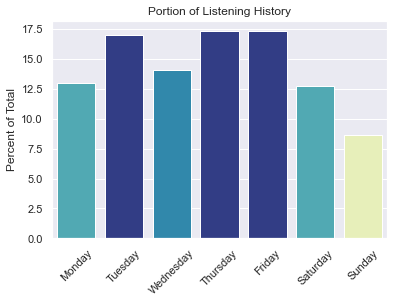

In [23]:
plt.figure()
sns.barplot(day_counts_percent.index, day_counts_percent.values, palette = colors_from_values(day_counts_percent.values))
plt.title('Portion of Listening History')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Above is the plot of the fraction of listening per day.  The general trend is that I listen to music more when I'm working during the week.  Saturdays have a healthy amount of listening, while Sundays are very inactive.

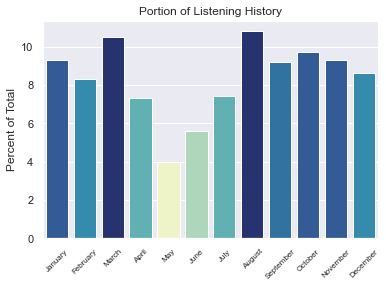

In [478]:
plt.figure()
sns.barplot(x = month_counts_percent_all.index, y = month_counts_percent_all.values, palette = colors_from_values(month_counts_percent_all.values))
plt.title('Portion of Listening History')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45, fontsize = 8)
plt.show()

This plot shows the fraction of listening split by month.  Not really sure if I hoped to see any trends here, since I would expect my listening habits to remain relatively throughout the year.  However, it is clear that May is slacking a bit -- after looking into this, I found out that ~half of my listening data in May 2018 was not recorded.  Let's take a look at 2019 only to see if it's more consistent across the board.

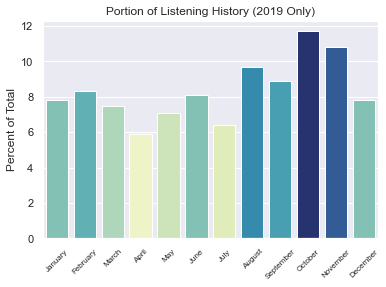

In [24]:
month_counts_percent_2019 = get_percents(df[df.datetime.dt.year == 2019].datetime.dt.month_name().value_counts().reindex(month_order))

plt.figure()
sns.barplot(x = month_counts_percent_2019.index, y = month_counts_percent_2019.values, palette = colors_from_values(month_counts_percent_2019.values))
plt.title('Portion of Listening History (2019 Only)')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45, fontsize = 8)
plt.show()

Not much to glean here other than the fact that I listened to a lot more music in the fall.  If I recall, I was very busy at work these months, so I guess the trend makes sense.

In [28]:
october_2019 = df[(df.datetime.dt.year == 2019) & (df.datetime.dt.month == 10)]
october_2019_listens = len(october_2019)
october_2019_most_listens = max(october_2019.datetime.dt.day.value_counts())
print(october_2019_listens, 'total listens in October 2019')
print('Highest amount of listens in one day:', october_2019_most_listens)

2772 total listens in October 2019
Highest amount of listens in one day: 220


Very likely that I fell asleep with a playlist on repeat on that day with 220 listens.

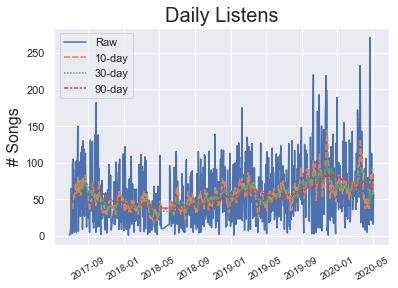

In [29]:
plt.figure()
sns.lineplot(data = multiline_plot_df)
plt.title('Daily Listens', fontsize = 20)
plt.ylabel('# Songs', fontsize=16)
plt.xticks(rotation=30, fontsize = 10)
plt.show()

This plot shows my daily listening trends since summer 2017.  Rolling averages are the dashed lines.

As expected, the raw data has too much noise to gather meaningful information from (you can even see in May 2018 where no data was recorded).  The rolling average lines do a good job of showing the general trend (the fall 2019 bump in activity is apparent as identified earlier).

## Most popular times

Now that we've seen my listening habits across days/months/years, let's dive into the daily breakdown.

In [30]:
# this will come in handy later ... 
hour_map = {0: '12 AM',
 1: '1 AM',
 2: '2 AM',
 3: '3 AM',
 4: '4 AM',
 5: '5 AM',
 6: '6 AM',
 7: '7 AM',
 8: '8 AM',
 9: '9 AM',
 10: '10 AM',
 11: '11 AM',
 12: '12 PM',
 13: '1 PM',
 14: '2 PM',
 15: '3 PM',
 16: '4 PM',
 17: '5 PM',
 18: '6 PM',
 19: '7 PM',
 20: '8 PM',
 21: '9 PM',
 22: '10 PM',
 23: '11 PM'}

Below, I gather the total listens per hour, then divide by the number of active days to get a view of average daily listens per hour.  

In [44]:
hour_counts = df.datetime.dt.hour.value_counts().sort_index().rename(hour_map)
average_hour_counts = hour_counts/unique_days
average_hour_counts

12 AM    1.119219
1 AM     0.776978
2 AM     0.730730
3 AM     0.659815
4 AM     0.590956
5 AM     0.647482
6 AM     0.608428
7 AM     0.775951
8 AM     2.708119
9 AM     2.896197
10 AM    2.413155
11 AM    2.562179
12 PM    3.154162
1 PM     4.046249
2 PM     4.390545
3 PM     4.005139
4 PM     3.909558
5 PM     4.940391
6 PM     4.541624
7 PM     3.393628
8 PM     2.548818
9 PM     2.247688
10 PM    1.786228
11 PM    1.361768
Name: datetime, dtype: float64

Before plotting, I create a new palette which maps the 'twilight_shifted' palette to the index (hours) to give a nice color gradient across the day.

In [46]:
day_palette = colors_from_values(np.array(list(hour_map.keys())), palette_name = 'twilight_shifted')

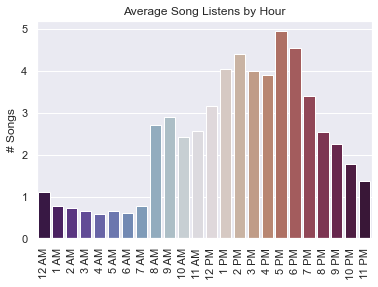

In [47]:
plt.figure()
sns.barplot(x = average_hour_counts.index, y = average_hour_counts.values, palette = day_palette)
plt.title('Average Song Listens by Hour')
plt.ylabel('# Songs', fontsize=12)
plt.xticks(rotation=90)
plt.show()

As expected, its unlikely for me to be listening to music in the middle of the night.  The first spike occurs at 8AM, when I'm commuting.  There appears to be a lull in the mid-morning as I get caught up in work and meetings.  There's a general trend upward post-lunch as I likely settle in at my desk, and then another spike around 5-6PM when I begin my commute home.  I also tend to keep music on after I get home, when making dinner, doing chores, etc.

These are general trends, since they encapsulate all days of the week.  My commuting habits dominate the view since they are roughly 5/7ths of my listening history.  To get a more granular view, let's look at the hourly breakdown by day.

## Hour breakdown, split by days

In [69]:
# grouping the dataframe based on day name 
grouped_days = df.groupby(df.datetime.dt.day_name())
# make sure the groupby index are sorted in the proper order of days 
grouped_days = sorted(grouped_days, key = lambda x: day_order.index(x[0]))

In [118]:
# get number of instances of each day
n_days = pd.to_datetime(df.datetime.dt.date.drop_duplicates()).dt.day_name().value_counts()
n_days

Wednesday    143
Monday       140
Thursday     140
Tuesday      139
Friday       139
Saturday     137
Sunday       135
Name: datetime, dtype: int64

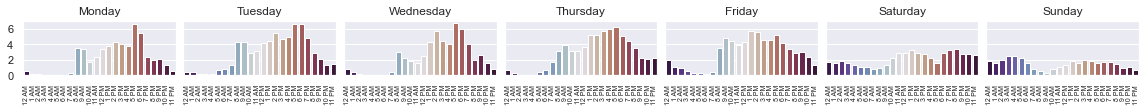

In [117]:
fig, axes = plt.subplots(nrows = 1, ncols = len(grouped_days), sharey = True, figsize=(20,1))
fig.subplots_adjust(wspace = 0.05)

plt.yticks(np.arange(0, max(hour_counts)/max(n_days), 2))

for ax, (day, sub_df) in zip(axes, grouped_days):
    # get daily hour counts, rename to readable hours (ex. '2 PM'), and sort in the proper manner
    day_hour_counts = sub_df.datetime.dt.hour.map(hour_map).value_counts().reindex(hour_map.values())
    # divide by number of instances of that day in order to get average daily counts 
    day_hour_counts /= n_days.loc[day]

    ax.set_title(day.capitalize())
    ax.tick_params(axis = 'x', rotation = 90, labelsize = 7)
    ax.set_xticklabels(['12AM', '6AM', '12PM', '6PM'])
    sns.barplot(x = day_hour_counts.index, y = day_hour_counts.values, ax = ax, palette = day_palette)

plt.show()

Above is the listening distribution for each day.  As expected, weekdays show mostly the same pattern.  Earlier in the week, I'm less likely to be listening to music at night.  On Tuesdays/Thursdays there is some volume starting at 5-6AM due to waking up early to go swim.  Friday and particularly Saturday nights have volume throughout the night .... 

# artist analysis

Let's take a look at some of my most played artists and songs.

In [120]:
top_10_artists = df.artist.value_counts().head(10)

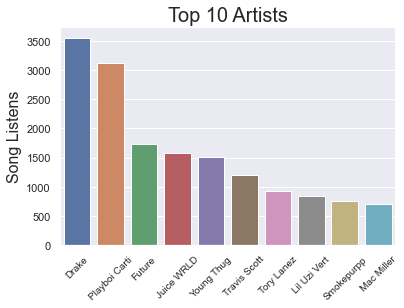

In [134]:
plt.figure()
sns.barplot(x = top_10_artists.index, y = top_10_artists.values, )
plt.title('Top 10 Artists', fontsize = 20)
plt.ylabel('Song Listens', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.show()

Who doesn't like Drake?  A close second is Playboi Carti.

As this is only a simple view, it doesn't tell the full story of _when_ I listened to these artists over time.  We can do this by isolating my listening history to each artist, and then plotting the individual time series to see how my interest evolved over time.

First, let's define a simple function that returns the time series for a given artist.

In [122]:
def get_artist_series(df, artist):
    return df[df.artist.str.contains(artist)].datetime.dt.date.value_counts().sort_index()

In [123]:
get_artist_series(df, 'Mac Miller')

2017-07-17    4
2017-07-18    1
2017-07-20    1
2017-07-21    1
2017-07-26    1
             ..
2020-04-13    2
2020-04-20    1
2020-04-24    2
2020-04-27    1
2020-04-28    1
Name: datetime, Length: 160, dtype: int64

This shows the number of times I listened to Mac Miller on each day.  Similar to our earlier analysis, it might be more useful to use a rolling average to view trends more cleanly.

Below, I'll create a dataframe with a 60-day rolling average time series for my top 5 most played artists.  Days where no listens were recorded for that artist will have a `NaN`

In [126]:
top_5_artists = df.artist.value_counts().head(5)

to_plot_artists = {artist: get_artist_series(df, artist).rolling(60).mean() for artist in top_5_artists.index}

multiline_plot_df_artist = pd.concat(to_plot_artists.values(), axis = 1).sort_index()
multiline_plot_df_artist.columns = to_plot_artists.keys()
multiline_plot_df_artist

,Drake,Playboi Carti,Future,Juice WRLD,Young Thug
2017-07-01,NaN,NaN,NaN,NaN,NaN
2017-07-04,NaN,NaN,NaN,NaN,NaN
2017-07-05,NaN,NaN,NaN,NaN,NaN
2017-07-06,NaN,NaN,NaN,NaN,NaN
2017-07-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-04-30,9.933333,6.766667,NaN,5.683333,3.833333
2020-05-01,10.650000,NaN,5.783333,NaN,NaN
2020-05-02,9.816667,NaN,5.783333,NaN,NaN
2020-05-03,9.800000,NaN,5.850000,NaN,NaN


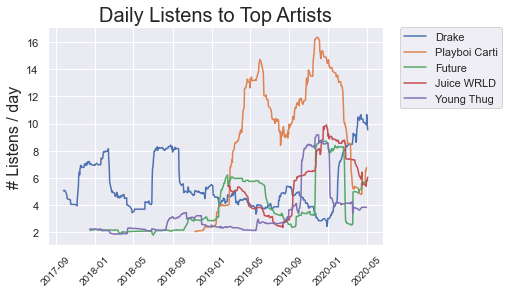

In [127]:
plt.figure()
sns.lineplot(data = multiline_plot_df_artist, dashes = False,)
plt.title('Daily Listens to Top Artists', fontsize = 20)
plt.ylabel('# Listens / day', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Here, we can see how much I listened to each individual artist over time.  

Clearly, Drake has always been a favorite, and gets consistent listens with some periods of elevated interest.  In the summer of 2018, you can see an elevated plateau which coincides with the release of his June 2018 album _Scorpion_.

Future and Young Thug have similar patterns, with consistent interest and brief periods of high-volume listening.  You can see a spike in listening to Future right at the beginning of 2019 which coincides with the release of his album _The Wizrd_.  Similarly, for Young Thug, there's a spike around September 2019 which falls right after the release of his album _So Much Fun_.

A standout here is Playboi Carti, and artist that I didn't start heavily listening to until around the beginning of 2019.  Evidently, my interest quickly outshined that in other artists and remained mostly throughout the past year despite him not releasing any other music (read:  I was listening to his two albums over and over).  Interest has waned over the past few months, but still remains up there with other artists.

Now let's take a look at my favorite songs in a similar fashion.  Similar to before, I can define a simple function to get the time series for a given song.

In [128]:
def get_song_series(df, song):
    return df[df.song == song].datetime.dt.date.value_counts().sort_index()

In [131]:
top_10_songs = df.groupby([df.song, df.artist]).size().sort_values(ascending = False).head(10)

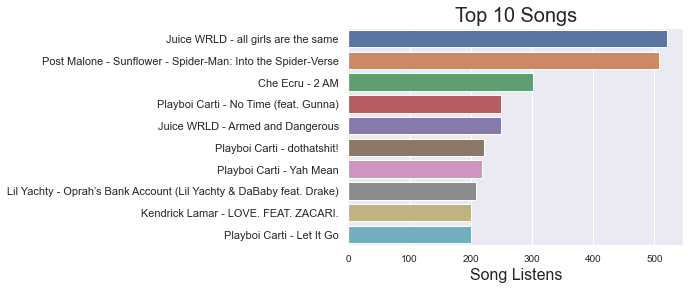

In [133]:
plt.figure()
song_titles = ['{} - {}'.format(artist, song) for song, artist in top_10_songs.index]
sns.barplot(y = song_titles, x = top_10_songs.values, orient = 'h')
plt.title('Top 10 Songs', fontsize = 20)
plt.xlabel('Song Listens', fontsize=16)
plt.xticks(rotation=0, fontsize = 10)
plt.show()

As you can see, Juice WRLD and Carti exist in my top artists mainly due to me listening to a few of their songs disproportionately -- Drake, Future, and Young Thug do not have any songs in my top 10.

I can personally attest to falling asleep leaving the spiderman/sunflower song on during two separate occasions ... 

Next, similar to with the artists, we can take a look at how I listened to these top songs over time.

In [135]:
top_5_songs = df.groupby([df.song, df.artist]).size().sort_values(ascending = False).head(5)

to_plot_songs = {'{} - {}'.format(artist, song): get_song_series(df, song).rolling(7).mean() for song, artist in top_5_songs.index}

multiline_plot_df_songs = pd.concat(to_plot_songs.values(), axis = 1).sort_index()
multiline_plot_df_songs.columns = to_plot_songs.keys()

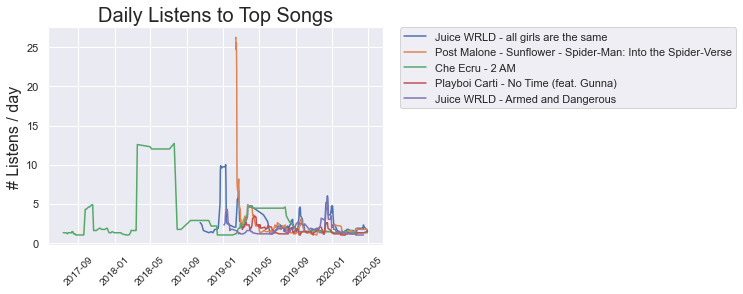

In [136]:
plt.figure()
sns.lineplot(data = multiline_plot_df_songs, dashes = False,)
plt.title('Daily Listens to Top Songs', fontsize = 20)
plt.ylabel('# Listens / day', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As mentioned, the spiderman/sunflower song suffered from massive overplaying when I initially found it, then interest tapered off.

Looking at the graph, it appears that (save for a few random spikes), many of these songs get consistent, low-volume interest over time.  I still listen to all of these songs regularly!

In [137]:
# convert to index.html with cmd line
!jupyter nbconvert to_publish.ipynb --to html --output index.html

[NbConvertApp] Converting notebook to_publish.ipynb to html
[NbConvertApp] Writing 1093111 bytes to index.html
